#  利用MxNet实现手写数字识别

## 一、训练模型

#### 导入相应的库

In [1]:
import mxnet as mx
import numpy as np
from mxnet import nd
import logging
import matplotlib.pyplot as plt
import os

In [2]:
def get_mnist_iter(data_source,batch_size):
    if data_source=='mnist':
        #读取MNISIT训练集
        train_data = mx.io.MNISTIter(
            image='./dataset-mnist/train-images-idx3-ubyte',
            label='./dataset-mnist/train-labels-idx1-ubyte',
            batch_size=batch_size,
            shuffle=1)
        #读取MNIST测试集
        val_data = mx.io.MNISTIter(
            image='./dataset-mnist/t10k-images-idx3-ubyte',
            label='./dataset-mnist/t10k-labels-idx1-ubyte',
            batch_size=batch_size,
            shuffle=0)
        return train_data,val_data

         

显示一张MNIST数据的图片，证明能够正常读取数据

/home/ma-user/anaconda3/envs/MXNet-1.2.1/lib/python3.6/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/home/ma-user/anaconda3/envs/MXNet-1.2.1/lib/python3.6/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


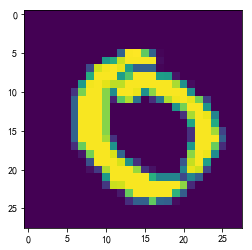

In [3]:
def plot_single_img():
    
    view_data=mx.io.MNISTIter(image='./dataset-mnist/train-images-idx3-ubyte',
                              label='./dataset-mnist/train-labels-idx1-ubyte',
                              batch_size=1)
    data_1=next(view_data)#从迭代器中取出数据使用next()函数
    data_2=data_1.data
    data_2=data_2[0][0][0][:][:]#降维成28*28
    data_4=data_2.asnumpy()
    return(data_4)
plt.imshow(plot_single_img())

In [4]:
#搭建lenet-5网络
def get_conv_symbol(num_classes=10):
    data = mx.sym.var('data')

    conv1 = mx.sym.Convolution(data=data, kernel=(3, 3), num_filter=10)
    relu1= mx.sym.Activation(data=conv1, act_type='relu')
    pool1 = mx.sym.Pooling(data=relu1, pool_type='max', kernel=(2, 2), stride=(2, 2))
    
    flatten = mx.sym.flatten(data=pool1)

    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=num_classes)
    relu2= mx.sym.Activation(data=fc1, act_type='relu')

    out = mx.sym.SoftmaxOutput(data=fc1, name='softmax')
    return out

In [ ]:

logging.getLogger().setLevel(logging.DEBUG)
conv=get_conv_symbol()
train_data,val_data=get_mnist_iter(data_source='mnist',batch_size=100)
devs = mx.gpu() 
conv_model = mx.mod.Module(symbol=conv, context=devs)
checkpoint=mx.callback.do_checkpoint('./output/')
batch_size=100
conv_model.fit(train_data=train_data,
              eval_data=val_data,
              optimizer='adam',#可选择不同优化器，adam,sgd
              optimizer_params={'learning_rate': 0.001},#可调整超参数学习率
              eval_metric=['acc','ce'],#准确率，交叉熵
              batch_end_callback=mx.callback.Speedometer(batch_size, 100),#每100批数据显示一次结果
              num_epoch=100,#训练轮数 
              epoch_end_callback=checkpoint)#模型保存路径